In [92]:
import numpy as np
import scipy as sp
import cv2
from cv2 import VideoWriter, VideoWriter_fourcc
import glob
import os
import multiprocessing
from joblib import Parallel, delayed
import pandas as pd
from scipy.spatial import ConvexHull, convex_hull_plot_2d


In [114]:
def centroid(vertexes):
    _x_list = [vertex [0] for vertex in vertexes]
    _y_list = [vertex [1] for vertex in vertexes]
    _len = len(vertexes)
    _x = sum(_x_list) / _len
    _y = sum(_y_list) / _len
    return(_x, _y)

def get_polygon(hull,points):
    x = []
    y = []
    for simplex in hull.simplices:
        x.append(points[simplex, 0])
        y.append(points[simplex, 1])
    return np.hstack(x),np.hstack(y)  

def get_center(points):
    try:
        hull = ConvexHull(points)
        x,y = get_polygon(hull,points)
        x,y = centroid(np.column_stack([x,y])) 
    except:
        x = np.median(points[:,0])
        y = np.median(points[:,1])
    return x,y

def write_avi_from_bitfield(nvt_data,data_path,width=720,height=480,FPS=30):
    numbers = nvt_data['points'].astype('int')
    ts = numbers.shape[0]
    # Intialize video codec
#     fourcc = VideoWriter_fourcc(*'DIVX')
#     video = VideoWriter(os.path.join(data_path,'VT1.avi'), fourcc, float(FPS), (width,height))
    # loop through points convert from decimal to binary and back to integer
    x_r = []
    y_r = []
    x_g = []
    y_g = []
    coords = pd.DataFrame()
    
    for cell in range(numbers.shape[0]):
        red = []
        green = []
        x = []
        y = []
        for sample in range(numbers.shape[1]):
            bin_number = "{0:b}".format(numbers[cell,sample]).zfill(32)
            red.append(int(bin_number[1],2))
            green.append(int(bin_number[2],2))
            x.append(int(bin_number[20:32],2))
            y.append(int(bin_number[4:16],2))
            
        # convert list to array 
        x = np.array(x)
        y = np.array(y)
        # account for zero-index and subtract 1 for all coordinates above zero 
        # (note. Neuralynx defaults missed tracking to 0,0 but this is not a true zero index)
        x[x > 0] = x[x > 0] - 1
        y[y > 0] = y[y > 0] - 1
        red = np.array(red)
        green = np.array(green)
        
        #remove out bound indicies
        x = remove_bad_x_inds(x,width)
        y = remove_bad_y_inds(y,height)
        
        # Create frame 
        red_points, green_points = create_frame_from_bitfield(x,y,red,green,width,height)
        x_,y_ = get_center(red_points)  
        x_r.append(x_)
        y_r.append(y_)
        
        x_,y_ = get_center(green_points)  
        x_g.append(x_)
        y_g.append(y_)
    
    coords['ts'] = nvt_data['time']
    coords['x_red'] = x_r
    coords['y_red'] = y_r
    coords['x_green'] = x_g
    coords['y_green'] = y_g

    return coords

#         return red_points, green_points
#         video.write(np.flip(frame, axis=2))

#     video.release()
#     cv2.destroyAllWindows()
#     print('video saved to: '+data_path)
    

def remove_bad_x_inds(x_all,width):
    # removes indicies outside of frame and defaults to 0
    x_all_idx = (x_all > width)
    x_all[x_all_idx] = 0
    return x_all

def remove_bad_y_inds(y_all,height):
    # removes indicies outside of frame and defaults to 0
    y_all_idx = (y_all > height)
    y_all[y_all_idx] = 0
    return y_all

def create_frame_from_bitfield(x_all,y_all,red_all,green_all,width,height):
    # Find points that correspond to red leds
    red_points = np.column_stack([x_all[red_all>0],y_all[red_all>0]])
    red_points = fill_points(red_points,width,height)
    # Find points that correspond to green leds
    green_points = np.column_stack([x_all[green_all>0],y_all[green_all>0]])
    # fill them
    green_points = fill_points(green_points,width,height)
    # initialize frame
#     rgbArray = np.zeros((height,width,3), 'uint8')
    # Add color to location of LED points
#     rgbArray[red_points[:,1],red_points[:,0], 0] = 255
#     rgbArray[green_points[:,1],green_points[:,0], 1] = 255
    return red_points, green_points

# Create fill_points function
def fill_points(points,width,height):
    new_points_x = []
    new_points_y = []
    # Fill x- points 
    for point in np.unique(points[:,1]): # unique y points
        temp_range_x = np.arange(np.min(points[points[:,1] == point][:,0])+1,np.max(points[points[:,1] == point][:,0]))
        if temp_range_x.size == 0:
            continue
        new_points_x.append(temp_range_x)
        new_points_y.append(np.tile(point,len(temp_range_x)))
        # Fill y- points 
    for point in np.unique(points[:,0]): # unique x points 
        temp_range_y = np.arange(np.min(points[points[:,0] == point][:,1])+1,np.max(points[points[:,0] == point][:,1]))
        if temp_range_y.size == 0:
            continue
        new_points_x.append(np.tile(point,len(temp_range_y)))
        new_points_y.append(temp_range_y)
        
    if (len(new_points_x) == 0) | (len(new_points_y) == 0):
        return points
    
    new_points = np.column_stack([np.hstack(new_points_x),np.hstack(new_points_y)])
#     new_points[new_points[:,0] > width] = 0
#     new_points[new_points[:,1] > height] = 0
    return new_points

# from https://github.com/vandermeerlab/nept/loaders_neuralynx.py 
def load_nvt(filename, remove_empty=False):
    """Loads a neuralynx .nvt file.
    Parameters
    ----------
    filename: str
    remove_empty: bool
    Returns
    -------
    nvt_data: dict
        With time, x, and y as keys.
    """
    with open(filename, "rb") as f:

        # Neuralynx files have a 16kbyte header
        header = f.read(16 * 2 ** 10)

        # The format for .nvt files according the the neuralynx docs is
        # uint16 - beginning of the record
        # uint16 - ID for the system
        # uint16 - size of videorec in bytes
        # uint64 - timestamp in microseconds
        # uint32 x 400 - points with the color bitfield values
        # int16 - unused
        # int32 - extracted X location of target
        # int32 - extracted Y location of target
        # int32 - calculated head angle in degrees clockwise from the positive Y axis
        # int32 x 50 - colored targets using the same bitfield format used to extract colors earlier
        dt = np.dtype(
            [
                ("filler1", "<h", 3),
                ("time", "<Q"),
                ("points", "<i", 400),
                ("filler2", "<h"),
                ("x", "<i"),
                ("y", "<i"),
                ("head_angle", "<i"),
                ("targets", "<i", 50),
            ]
        )
        data = np.fromfile(f, dt)

    nvt_data = dict()
    nvt_data["time"] = data["time"] * 1e-6
    nvt_data["x"] = np.array(data["x"], dtype=float)
    nvt_data["y"] = np.array(data["y"], dtype=float)
    nvt_data["points"] = np.array(data["points"], dtype=float)

    empty_idx = (data["x"] == 0) & (data["y"] == 0)
    for key in nvt_data:
        if remove_empty:
            nvt_data[key] = nvt_data[key][~empty_idx]

    return nvt_data

def main(file):
    if os.path.exists(os.path.join(file,'VT1.avi')):
        return
    nvt_data = load_nvt(os.path.join(file,'VT1.nvt'))
    write_avi_from_bitfield(nvt_data,file)

In [2]:
# num_cores = multiprocessing.cpu_count()

files = glob.glob('F:/Projects/PAE_PlaceCell/data/**/*.nvt', recursive=True)
files = [item.split('VT1.nvt')[0] for item in files]
# processed_list = Parallel(n_jobs=num_cores)(delayed(main)(file) for file in files)

In [115]:
file = files[0]
nvt_data = load_nvt(os.path.join(file,'VT1.nvt'))
coords = write_avi_from_bitfield(nvt_data,file)

D:\ryanh\Anaconda3\envs\ripple_analysis\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\ryanh\Anaconda3\envs\ripple_analysis\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [132]:
file

'F:/Projects/PAE_PlaceCell/data\\LE2813\\2017-09-20_11-51-22\\'

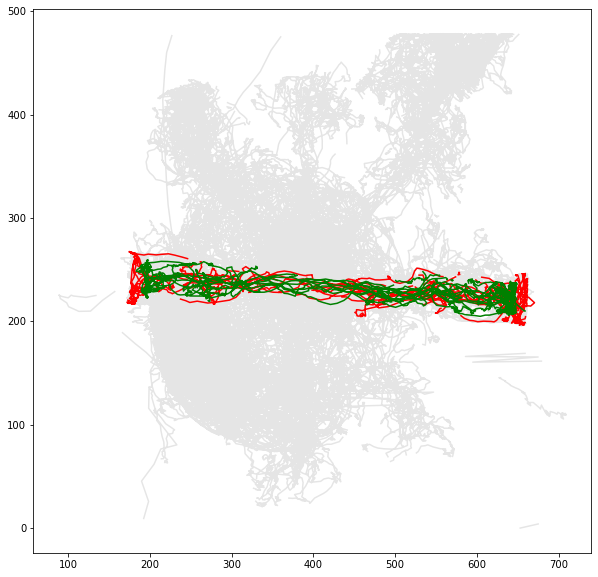

In [133]:
plt.figure(figsize=(10,10))
plt.plot(coords.x_red,coords.y_red,color='k',alpha=.1)

seg = [0,30*100]
plt.plot(coords.x_red.iloc[seg[0]:seg[1]],coords.y_red.iloc[seg[0]:seg[1]],color='r')
plt.plot(coords.x_green.iloc[seg[0]:seg[1]],coords.y_green.iloc[seg[0]:seg[1]],color='g')

# plt.figure(figsize=(20,3))
# plt.plot(coords.ts,coords.x_red,'.r',alpha=.2)
# plt.figure(figsize=(20,3))
# plt.plot(coords.ts,coords.y_red,'.r',alpha=.2)
# plt.figure(figsize=(20,3))
# plt.plot(coords.ts,coords.x_green,'.g',alpha=.2)
# plt.figure(figsize=(20,3))
# plt.plot(coords.ts,coords.y_green,'.g',alpha=.2)



In [84]:
def centroid(vertexes):
    _x_list = [vertex [0] for vertex in vertexes]
    _y_list = [vertex [1] for vertex in vertexes]
    _len = len(vertexes)
    _x = sum(_x_list) / _len
    _y = sum(_y_list) / _len
    return(_x, _y)

def get_polygon(hull,points):
    x = []
    y = []
    for simplex in hull.simplices:
        x.append(points[simplex, 0])
        y.append(points[simplex, 1])
    return np.hstack(x),np.hstack(y)  

def get_center(points):
    hull = ConvexHull(points)
    x,y = get_polygon(hull,points)
    x,y = centroid(np.column_stack([x,y]))
    return x,y

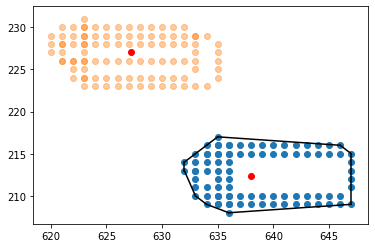

In [87]:
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, convex_hull_plot_2d

hull = ConvexHull(red_points)

for simplex in hull.simplices:
    plt.plot(red_points[simplex, 0], red_points[simplex, 1], 'k-')
    
plt.scatter(red_points[:,0],red_points[:,1])
x,y = get_center(red_points)  
plt.scatter(x,y,color='r')


# hull = ConvexHull(green_points)
# x,y = get_polygon(hull,green_points)

# plt.scatter(x,y,color='k')
# x,y = centroid(np.column_stack([x,y]))
# plt.scatter(x,y,color='r')

# for simplex in hull.simplices:
# plt.plot(green_points[hull.simplices[:,0],0], green_points[hull.simplices[:,1],1], 'k-')
x,y = get_center(green_points)  
plt.scatter(x,y,color='r')
plt.scatter(green_points[:,0],green_points[:,1],alpha=.4)

# centroid(vertexes)